# Tasman Agentic Analytics - Phase 1 Demo

This notebook demonstrates the **local-first agentic analytics system** with minimal LLM usage.

**Key Features:**
- Rule-based triage (search vs analysis)
- Template-based SQL generation
- LLM fallback only when needed
- Automatic visualization
- Full observability of each step

---

## 1. Setup & Validation

Load configuration, connect to DuckDB, and validate schema.

In [1]:
import os
import sys
import json
from pathlib import Path
from pprint import pprint

import pandas as pd
import yaml
from IPython.display import display, Image, Markdown

# Add parent directory to path for imports
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Import our modules
from core.duckdb_connector import DuckDBConnector
from core.triage_local import LocalTriage
from core.local_text_to_sql import LocalTextToSQL
from core.llm_clients import LLMClient
from agents.agent_triage import TriageAgent
from agents.agent_text_to_sql import TextToSQLAgent
from agents.agent_search import SearchAgent

print("✅ Imports successful")

✅ Imports successful


In [2]:
# Load environment variables
try:
    from dotenv import load_dotenv
    load_dotenv(PROJECT_ROOT / ".env")
    print("✅ Environment loaded")
except Exception as e:
    print(f"ℹ️  No .env file or dotenv not available: {e}")

# Setup directories
CONFIG_DIR = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
CACHE_DIR = PROJECT_ROOT / ".cache" / "llm"
OUTPUT_DIR = Path.cwd() / "outputs"

for d in (CACHE_DIR, OUTPUT_DIR):
    d.mkdir(parents=True, exist_ok=True)

print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Output dir: {OUTPUT_DIR}")

✅ Environment loaded
📁 Project root: /Users/thomas/Documents/GitHub/tasman-marketing-agent
📁 Output dir: /Users/thomas/Documents/GitHub/tasman-marketing-agent/notebooks/outputs


In [3]:
# Load configuration files
def load_yaml(path: Path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

db_config = load_yaml(CONFIG_DIR / "db.yaml")
business_context = load_yaml(CONFIG_DIR / "business_context.yaml")
templates = load_yaml(CONFIG_DIR / "sql_templates.yaml")

with open(CONFIG_DIR / "schema.json", 'r') as f:
    schema = json.load(f)

print("✅ Configuration loaded")
print(f"   - {len(schema)} tables in schema")
print(f"   - {len(templates)} SQL templates")
print(f"   - {len(business_context['roles'])} roles configured")

✅ Configuration loaded
   - 8 tables in schema
   - 6 SQL templates
   - 4 roles configured


In [ ]:
# Get DuckDB path from config with environment variable override
# Priority: DUCKDB_PATH env var > db.yaml config > default
DUCKDB_PATH = os.getenv('DUCKDB_PATH')
if DUCKDB_PATH:
    DUCKDB_PATH = Path(DUCKDB_PATH)
    print("🔧 Using DUCKDB_PATH from environment variable")
else:
    # Use path from config file (relative to project root)
    db_path_str = db_config.get('duckdb_path', './data/synthetic_data.duckdb')
    DUCKDB_PATH = PROJECT_ROOT / db_path_str.lstrip('./')
    print("📋 Using duckdb_path from config/db.yaml")

DEFAULT_LIMIT = db_config.get('default_limit', 1000)

print(f"🦆 DuckDB path: {DUCKDB_PATH}")
print(f"🔢 Default limit: {DEFAULT_LIMIT}")

# Check if DB exists
if not DUCKDB_PATH.exists():
    print(f"\n⚠️  WARNING: DuckDB file not found at {DUCKDB_PATH}")
    print("   You'll need to create this database before running queries.")
    print("   Run: make sample-data")
    print("   The notebook will continue but queries will fail.")
else:
    print("✅ DuckDB file exists")

In [5]:
# Initialize database connector
db_connector = DuckDBConnector(str(DUCKDB_PATH), default_limit=DEFAULT_LIMIT)

try:
    db_connector.connect()
    print("✅ Connected to DuckDB")
    
    # List tables
    tables = db_connector.list_tables()
    print(f"\n📦 Tables in database ({len(tables)}):")
    for table in tables:
        print(f"   - {table}")
    
    # Validate schema
    is_valid, errors = db_connector.validate_schema(schema)
    
    if is_valid:
        print("\n✅ Schema validation passed")
    else:
        print("\n❌ Schema validation failed:")
        for error in errors:
            print(f"   - {error}")
        
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("   Notebook will continue but queries will fail.")

✅ Connected to DuckDB

📦 Tables in database (8):
   - dim_adgroups
   - dim_campaigns
   - dim_creatives
   - dim_customers
   - dim_products
   - fact_ad_spend
   - fact_orders
   - fact_sessions

❌ Schema validation failed:
   - Missing column: dim_products.margin
   - Missing column: dim_customers.acquisition_channel
   - Missing column: fact_sessions.device


## 2. Configure LLM (Optional)

Set up LLM client for fallback. The system will work without LLM for known query patterns.

In [6]:
# Configure LLM provider
MODEL_PROVIDER = os.getenv("MODEL_PROVIDER", "openai").lower()
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
ANTHROPIC_MODEL = os.getenv("ANTHROPIC_MODEL", "claude-3-5-haiku-20241022")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

print(f"🤖 LLM Provider: {MODEL_PROVIDER}")

# Initialize LLM client (optional)
llm_client = None

try:
    if MODEL_PROVIDER == "openai" and OPENAI_API_KEY:
        llm_client = LLMClient(
            provider="openai",
            cache_dir=CACHE_DIR,
            temperature=0.2,
            max_tokens=512
        )
        print(f"✅ OpenAI client initialized (model: {OPENAI_MODEL})")
        
    elif MODEL_PROVIDER == "anthropic" and ANTHROPIC_API_KEY:
        llm_client = LLMClient(
            provider="anthropic",
            cache_dir=CACHE_DIR,
            temperature=0.2,
            max_tokens=512
        )
        print(f"✅ Anthropic client initialized (model: {ANTHROPIC_MODEL})")
    else:
        print("ℹ️  No API key found - running in local-only mode")
        print("   Templates will handle known queries; unknown queries will fail gracefully.")
        
except Exception as e:
    print(f"⚠️  LLM initialization failed: {e}")
    print("   Continuing in local-only mode.")
    llm_client = None

🤖 LLM Provider: openai
✅ OpenAI client initialized (model: gpt-4o-mini)


## 3. Initialize Agents

Set up triage, text-to-SQL, and search agents.

In [7]:
# Initialize agents
triage_agent = TriageAgent(
    business_context=business_context,
    llm_client=llm_client,
    llm_threshold=0.6
)

text_to_sql_agent = TextToSQLAgent(
    templates=templates,
    schema=schema,
    business_context=business_context,
    llm_client=llm_client,
    llm_threshold=0.6,
    default_limit=DEFAULT_LIMIT
)

search_agent = SearchAgent(
    triage_agent=triage_agent,
    text_to_sql_agent=text_to_sql_agent,
    db_connector=db_connector,
    output_dir=OUTPUT_DIR
)

print("✅ Agents initialized")
print("   - TriageAgent: Rule-based + optional LLM fallback")
print("   - TextToSQLAgent: Template matching + optional LLM")
print("   - SearchAgent: End-to-end orchestration")

✅ Agents initialized
   - TriageAgent: Rule-based + optional LLM fallback
   - TextToSQLAgent: Template matching + optional LLM
   - SearchAgent: End-to-end orchestration


## 4. Business Context & Templates

Explore available roles, KPIs, and SQL templates.

In [8]:
# Display available roles and their KPIs
print("👥 Available Roles:\n")

for role_name, role_config in business_context['roles'].items():
    print(f"**{role_name.upper()}**")
    print(f"  KPIs: {', '.join(role_config['kpis'])}")
    print(f"  Dimensions: {', '.join(role_config['dims'][:5])}...")
    print(f"  Time window: {role_config['defaults']['time_window_days']} days")
    print()

👥 Available Roles:

**MARKETER**
  KPIs: spend, impressions, clicks, ctr, cvr, cac, roas, revenue, margin
  Dimensions: channel, campaign_name, audience, placement, device...
  Time window: 90 days

**CEO**
  KPIs: revenue, margin, growth, cac, ltv, roas
  Dimensions: channel, region, brand, category...
  Time window: 180 days

**CPO**
  KPIs: orders, revenue, margin, attach_rate, conversion_rate
  Dimensions: sku, category, subcategory, brand...
  Time window: 120 days

**COO**
  KPIs: orders, fulfillment_rate, cancellations, margin, revenue
  Dimensions: region, category, device...
  Time window: 120 days



In [9]:
# Display available SQL templates
print("📋 Available SQL Templates:\n")

for i, template in enumerate(templates, 1):
    print(f"{i}. **{template['id']}**")
    print(f"   Role: {template.get('role_hint', 'any')}")
    print(f"   Example questions:")
    for utterance in template['utterances'][:2]:
        print(f"     - \"{utterance}\"")
    print()

📋 Available SQL Templates:

1. **spend_by_channel_over_time**
   Role: marketer
   Example questions:
     - "spend by channel"
     - "show ad spend per channel over time"

2. **ctr_by_campaign**
   Role: marketer
   Example questions:
     - "ctr by campaign"
     - "which campaigns have the best click-through rate"

3. **orders_and_revenue_by_category**
   Role: ceo
   Example questions:
     - "orders by category"
     - "revenue by product category"

4. **roas_by_channel**
   Role: ceo
   Example questions:
     - "roas by channel"
     - "which channel is most efficient"

5. **device_sessions_and_cvr**
   Role: marketer
   Example questions:
     - "conversion rate by device"
     - "sessions and cvr by device"

6. **margin_by_brand**
   Role: cpo
   Example questions:
     - "margin by brand"
     - "which brands contribute most margin"



## 5. Ask Questions

Now let's ask questions and see the system in action!

In [10]:
# Helper function to display results
def display_result(result):
    """Display search result in a nice format."""
    print("="*80)
    print(f"QUESTION: {result['question']}")
    print(f"ROLE: {result.get('role', 'auto-detected')}")
    print("="*80)
    
    # Show steps
    print("\n📋 STEPS:")
    for step in result['steps']:
        step_name = step['step'].replace('_', ' ').title()
        used_llm = step.get('used_llm', False)
        llm_indicator = "🤖 (LLM)" if used_llm else "⚡ (Local)"
        print(f"  {step_name}: {llm_indicator}")
        if 'confidence' in step:
            print(f"    Confidence: {step['confidence']:.2f}")
        if 'method' in step:
            print(f"    Method: {step['method']}")
    
    # Show status
    status = result.get('status', 'unknown')
    print(f"\n📊 STATUS: {status}")
    
    if status != 'success':
        print(f"\n⚠️  {result.get('message', 'Unknown error')}")
        if 'errors' in result:
            for error in result['errors']:
                print(f"   - {error}")
        return
    
    # Show SQL
    if 'sql' in result:
        print("\n💾 SQL QUERY:")
        print("```sql")
        print(result['sql'])
        print("```")
    
    # Show data preview
    if 'data' in result and not result['data'].empty:
        print(f"\n📊 RESULTS ({result['row_count']} rows):")
        display(result['data'].head(10))
    
    # Show visualization
    if result.get('chart_path'):
        print(f"\n📈 VISUALIZATION ({result['chart_type']}):")
        display(Image(filename=str(result['chart_path'])))
    
    # Show summary
    if 'summary' in result:
        print(f"\n📝 SUMMARY:")
        print(f"   {result['summary']}")
    
    print("\n" + "="*80 + "\n")

### Example 1: Template-matched query (local, no LLM)

In [11]:
# This should match a template and NOT call LLM
result = search_agent.search(
    question="show ad spend per channel over time",
    role="marketer"
)

display_result(result)

QUESTION: show ad spend per channel over time
ROLE: marketer

📋 STEPS:
  Triage: ⚡ (Local)
    Confidence: 0.70
  Sql Generation: ⚡ (Local)
    Confidence: 1.00
    Method: template_match
  Execution: ⚡ (Local)
  Visualization: ⚡ (Local)

📊 STATUS: success

💾 SQL QUERY:
```sql
SELECT c.channel,
       f.date,
       SUM(f.spend) AS total_spend
FROM fact_ad_spend f
JOIN dim_campaigns c ON f.campaign_id = c.campaign_id
WHERE f.date >= CURRENT_DATE - INTERVAL 90 DAY
GROUP BY 1,2
ORDER BY 2 ASC, 1
LIMIT 10000;

```

📊 RESULTS (44 rows):


,channel,date,total_spend
0,meta,2025-09-03,5025.43
1,snapchat,2025-09-03,839.96
2,google_shopping,2025-09-04,2973.31
3,meta,2025-09-04,5711.48
4,snapchat,2025-09-04,913.39
5,google_shopping,2025-09-05,3001.54
6,meta,2025-09-05,6706.04
7,snapchat,2025-09-05,904.08
8,google_shopping,2025-09-06,3643.00
9,meta,2025-09-06,15774.04



📝 SUMMARY:
   Query returned 44 rows and 3 columns. total_spend ranges from 839.96 to 15774.04.




### Example 2: Another template-matched query

QUESTION: which campaigns have the best click-through rate
ROLE: marketer

📋 STEPS:
  Triage: 🤖 (LLM)
    Confidence: 0.90
  Sql Generation: ⚡ (Local)
    Confidence: 1.00
    Method: template_match
  Execution: ⚡ (Local)
  Visualization: ⚡ (Local)

📊 STATUS: success

💾 SQL QUERY:
```sql
SELECT c.campaign_name,
       SUM(f.impressions) AS impressions,
       SUM(f.clicks) AS clicks,
       CASE WHEN SUM(f.impressions)=0 THEN NULL
            ELSE SUM(f.clicks)::DOUBLE / SUM(f.impressions) END AS ctr
FROM fact_ad_spend f
JOIN dim_campaigns c ON f.campaign_id = c.campaign_id
WHERE f.date >= CURRENT_DATE - INTERVAL 90 DAY
GROUP BY 1
ORDER BY ctr DESC NULLS LAST
LIMIT 10000;

```

📊 RESULTS (10 rows):


,campaign_name,impressions,clicks,ctr
0,Google_Search Traffic Campaign 1,669568.0,25022.0,0.037370
1,Google_Shopping Conversion Campaign 3,470257.0,17537.0,0.037292
2,Google_Shopping Traffic Campaign 5,1288853.0,37718.0,0.029265
3,Meta Conversion Campaign 4,1773701.0,46823.0,0.026398
4,Meta Conversion Campaign 6,600166.0,15732.0,0.026213
5,Meta Conversion Campaign 8,750033.0,17977.0,0.023968
6,Meta Conversion Campaign 10,897932.0,21514.0,0.023959
7,Meta Conversion Campaign 2,2145028.0,41509.0,0.019351
8,Snapchat Conversion Campaign 7,679717.0,13005.0,0.019133
9,Snapchat Conversion Campaign 9,1342990.0,17761.0,0.013225



📈 VISUALIZATION (bar):


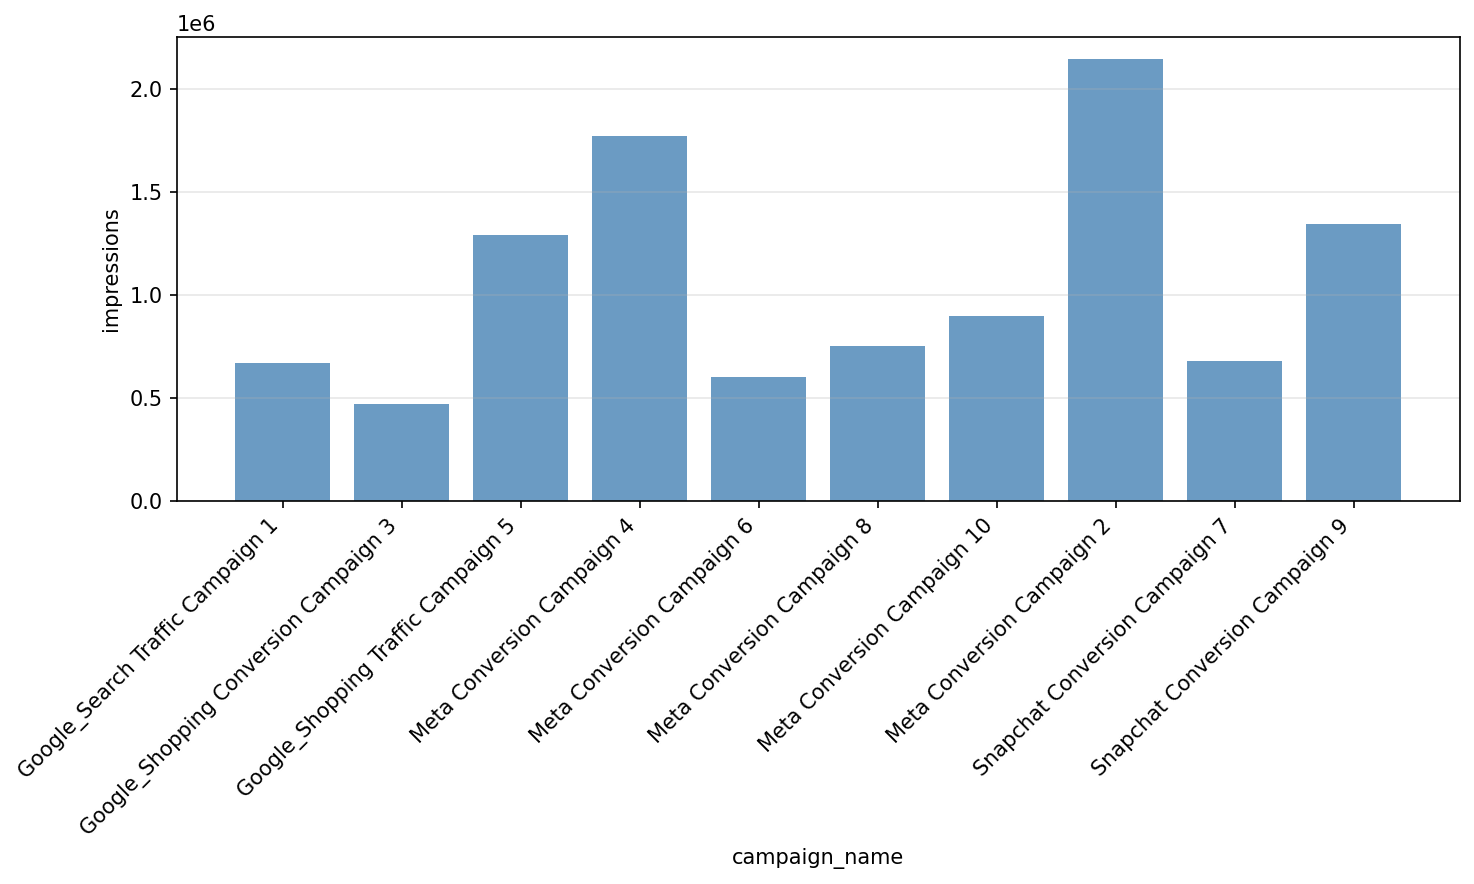


📝 SUMMARY:
   Query returned 10 rows and 4 columns. impressions ranges from 470257.00 to 2145028.00. Chart saved to chart_54557.png.




In [12]:
result = search_agent.search(
    question="which campaigns have the best click-through rate",
    role="marketer"
)

display_result(result)

### Example 3: CEO perspective query

In [13]:
result = search_agent.search(
    question="revenue by product category",
    role="ceo"
)

display_result(result)

QUESTION: revenue by product category
ROLE: ceo

📋 STEPS:
  Triage: ⚡ (Local)
    Confidence: 0.60
  Sql Generation: ⚡ (Local)
    Confidence: 1.00
    Method: template_match
  Execution: ⚡ (Local)

📊 STATUS: execution_failed

⚠️  SQL execution failed: Query execution failed: Binder Error: Cannot compare values of type TIMESTAMP_NS and type TIMESTAMP WITH TIME ZONE - an explicit cast is required

LINE 7: WHERE o.order_timestamp >= NOW() - INTERVAL 180 DAY
                                ^
SQL: SELECT p.category,
       COUNT(DISTINCT o.order_id) AS orders,
       SUM(o.revenue) AS revenue,
       SUM(o.margin)  AS margin
FROM fact_orders o
JOIN dim_products p ON o.sku = p.sku
WHERE o.order_timestamp >= NOW() - INTERVAL 180 DAY
GROUP BY 1
ORDER BY revenue DESC
LIMIT 10000;



### Example 4: Novel query (may trigger LLM if available)

In [14]:
# This is a novel query not in templates - will try LLM if available
result = search_agent.search(
    question="what are the top 10 products by revenue in the last 30 days?",
    role="cpo"
)

display_result(result)

QUESTION: what are the top 10 products by revenue in the last 30 days?
ROLE: cpo

📋 STEPS:
  Triage: ⚡ (Local)
    Confidence: 0.80
  Sql Generation: 🤖 (LLM)
    Confidence: 0.80
    Method: llm
  Execution: ⚡ (Local)
  Visualization: ⚡ (Local)

📊 STATUS: success

💾 SQL QUERY:
```sql
SELECT sku, SUM(revenue) AS total_revenue
FROM fact_orders
WHERE order_timestamp >= CURRENT_DATE - INTERVAL '30 DAY'
GROUP BY sku
ORDER BY total_revenue DESC
LIMIT 10;
```

📝 SUMMARY:
   Query returned no results.




### Example 5: Auto role detection

In [15]:
# No role specified - system will infer from question content
result = search_agent.search(
    question="conversion rate by device"
)

display_result(result)

QUESTION: conversion rate by device
ROLE: marketer

📋 STEPS:
  Triage: ⚡ (Local)
    Confidence: 0.60
  Sql Generation: ⚡ (Local)
    Confidence: 1.00
    Method: template_match
  Execution: ⚡ (Local)

📊 STATUS: execution_failed

⚠️  SQL execution failed: Query execution failed: Binder Error: Table "s" does not have a column named "device"

Candidate bindings: : "device_type"

LINE 1: SELECT s.device,
               ^
SQL: SELECT s.device,
       COUNT(*) AS sessions,
       SUM(CASE WHEN s.converted_flag THEN 1 ELSE 0 END) AS conversions,
       CASE WHEN COUNT(*)=0 THEN NULL
            ELSE SUM(CASE WHEN s.converted_flag THEN 1 ELSE 0 END)::DOUBLE / COUNT(*) END AS cvr
FROM fact_sessions s
WHERE s.date >= CURRENT_DATE - INTERVAL 90 DAY
GROUP BY 1
ORDER BY cvr DESC NULLS LAST
LIMIT 10000;



## 6. Observability & Debugging

Inspect the internal workings of the system.

In [16]:
# Detailed view of triage result
test_question = "show me the top spending campaigns"

triage_result = triage_agent.triage(test_question, role="marketer")
print("🔍 TRIAGE RESULT:\n")
pprint(triage_result)

🔍 TRIAGE RESULT:

{'analysis_type': None,
 'confidence': 0.7,
 'inferred_role': 'marketer',
 'method': 'local_rules',
 'mode': 'search',
 'reason': 'Detected 2 search keyword(s): descriptive query pattern',
 'used_llm': False}


In [17]:
# Detailed view of SQL generation
sql_result = text_to_sql_agent.generate_sql(test_question, role="marketer")
print("🔍 SQL GENERATION RESULT:\n")
pprint(sql_result)

🔍 SQL GENERATION RESULT:

{'confidence': 0.8,
 'local_result': {'confidence': 0.0,
                  'entities': {'dimensions': [],
                               'kpis': ['spend'],
                               'time_ranges': []},
                  'method': 'no_match',
                  'sql': None,
                  'template_id': None,
                  'valid': False,
                  'validation_errors': ['No template match found']},
 'method': 'llm',
 'sql': 'SELECT \n'
        '    c.campaign_name,\n'
        '    SUM(f.spend) AS total_spend\n'
        'FROM \n'
        '    fact_ad_spend f\n'
        'JOIN \n'
        '    dim_campaigns c ON f.campaign_id = c.campaign_id\n'
        'WHERE \n'
        "    f.date >= CURRENT_DATE - INTERVAL '90 days'\n"
        'GROUP BY \n'
        '    c.campaign_name\n'
        'ORDER BY \n'
        '    total_spend DESC\n'
        'LIMIT 1000;',
 'used_llm': True,
 'valid': True,
 'validation_errors': []}


## 7. Test Cells

Quick smoke tests to ensure everything works.

In [18]:
# Test 1: Schema validation
print("TEST 1: Schema Validation")
is_valid, errors = db_connector.validate_schema(schema)
assert is_valid, f"Schema validation failed: {errors}"
print("✅ PASSED\n")

# Test 2: Template coverage
print("TEST 2: Template Coverage")
test_questions = [
    ("spend by channel", "marketer"),
    ("ctr by campaign", "marketer"),
    ("orders by category", "ceo"),
]

for question, role in test_questions:
    result = text_to_sql_agent.generate_sql(question, role)
    assert result['sql'] is not None, f"Failed to generate SQL for: {question}"
    assert result['method'] == 'template_match', f"Expected template match for: {question}"
    print(f"  ✓ {question}")

print("✅ PASSED\n")

# Test 3: Triage classification
print("TEST 3: Triage Classification")
search_questions = ["show me revenue", "how many orders", "plot spend by channel"]
analysis_questions = ["why did revenue drop", "identify drivers of conversion", "segment customers"]

for q in search_questions:
    result = triage_agent.triage(q)
    assert result['mode'] == 'search', f"Expected 'search' for: {q}"
    print(f"  ✓ '{q}' → search")

for q in analysis_questions:
    result = triage_agent.triage(q)
    assert result['mode'] == 'analysis', f"Expected 'analysis' for: {q}"
    print(f"  ✓ '{q}' → analysis")

print("✅ PASSED\n")

print("🎉 ALL TESTS PASSED")

TEST 1: Schema Validation


AssertionError: Schema validation failed: ['Missing column: dim_products.margin', 'Missing column: dim_customers.acquisition_channel', 'Missing column: fact_sessions.device']

## 8. Interactive Query Interface

Try your own questions!

In [ ]:
# Interactive query
YOUR_QUESTION = "show me conversion rate by device"  # ← Change this!
YOUR_ROLE = "marketer"  # ← Change this! Options: marketer, ceo, cpo, coo, or None for auto-detect

result = search_agent.search(
    question=YOUR_QUESTION,
    role=YOUR_ROLE if YOUR_ROLE != "None" else None
)

display_result(result)

## 9. Cache Statistics

Check LLM cache hits/misses.

In [ ]:
# Count cache files
if CACHE_DIR.exists():
    cache_files = list(CACHE_DIR.glob("*.json"))
    print(f"📦 LLM Cache Statistics:")
    print(f"   Total cached responses: {len(cache_files)}")
    print(f"   Cache directory: {CACHE_DIR}")
    
    if len(cache_files) > 0:
        print("\n   Recent cache entries:")
        for cache_file in sorted(cache_files, key=lambda f: f.stat().st_mtime, reverse=True)[:5]:
            with open(cache_file, 'r') as f:
                data = json.load(f)
                key_parts = data.get('key_parts', [])
                if len(key_parts) > 2:
                    print(f"     - {key_parts[0]} call: {key_parts[-1][:50]}...")
else:
    print("ℹ️  No cache directory found")

## 10. Cleanup

Close database connection.

In [ ]:
# Close database connection
db_connector.close()
print("✅ Database connection closed")